In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import ResNet50
from keras.applications import MobileNet
from keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.resnet_v2 import preprocess_input
from keras.applications.mobilenet import preprocess_input
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import regularizers

Using TensorFlow backend.
C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\yotam hermon\Anacond

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
# setting up the gpu configuration 

In [3]:
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)
# using node workers to accelerate the computing time, please note, if your machine has different cpu/gpu count, this is the place to set up the right number

In [39]:
def validation(model, train_datagen):
    # model=Model(inputs=base_model.input,outputs=preds)
    # model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
    val_generator=train_datagen.flow_from_directory('../data/validation/', # this is where you specify the path to the main data folder
                                                     target_size=(224,224),
                                                     color_mode='rgb',
                                                     batch_size=16,
                                                     class_mode='categorical',                                                 
                                                     shuffle=True)

    step_size_val=val_generator.n//val_generator.batch_size
    history1 = model.fit_generator(generator=val_generator,
                       steps_per_epoch=step_size_val,
                       epochs=5)
    return history1

In [5]:
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(6,activation='softmax')(x) #final layer with softmax activation

C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [6]:
model=Model(inputs=base_model.input,outputs=preds) # creating a model object, the inputs is base model, and the output of the model is preds
# uniting all the layers together to create complete model

In [7]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True
# defining the training depth of our model

In [8]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) # Generate batches of tensor image data with real-time data augmentation. 
# The data will be looped over (in batches).
# creating image data generator, flowing data from directory

train_generator=train_datagen.flow_from_directory('../Data_for_TIMIT/Train/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',                                                 
                                                 shuffle=True)

Found 18000 images belonging to 6 classes.


In [9]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy']) # at this point we choose the parameters of our network
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=5)


Epoch 1/5
562/562 [==============================] - 67s 118ms/step - loss: 0.4088 - accuracy: 0.8510
Epoch 2/5
562/562 [==============================] - 62s 111ms/step - loss: 0.2738 - accuracy: 0.8997
Epoch 3/5
562/562 [==============================] - 62s 110ms/step - loss: 0.2365 - accuracy: 0.9108
Epoch 4/5
562/562 [==============================] - 62s 111ms/step - loss: 0.2253 - accuracy: 0.9188
Epoch 5/5
562/562 [==============================] - 62s 110ms/step - loss: 0.1963 - accuracy: 0.9251


In [11]:
x=model.layers[-6].output # uniting the pre trained TIMIT model from the previous stage with new model to be trained in the next stage
# next stage of training is TikTalk data set.
# The '-5' removing 5 last layers  
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.

x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='softmax',activity_regularizer=regularizers.l2(1e-5))(x) #final layer with softmax activation

model_tiktalk=Model(inputs=model.input,outputs=preds)

for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True
    
train_datagen_tiktalk=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
val_datagen_tiktalk=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator_tiktalk=train_datagen_tiktalk.flow_from_directory('../data/train/classification/', # this is where you specify the path to the main data folder
                                                                         target_size=(224,224),
                                                                         color_mode='rgb',
                                                                         batch_size=32,
                                                                         class_mode='categorical',                                                 
                                                                         shuffle=True)


val_generator=val_datagen_tiktalk.flow_from_directory('../data/validation/', # this is where you specify the path to the main data folder
                                                     target_size=(224,224),
                                                     color_mode='rgb',
                                                     batch_size=32,
                                                     class_mode='categorical',                                                 
                                                     shuffle=True)

Found 2970 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [12]:
model_tiktalk.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train_tiktalk=train_generator_tiktalk.n//train_generator_tiktalk.batch_size
history_tiktalk = model_tiktalk.fit_generator(generator=train_generator_tiktalk,
                                                       steps_per_epoch=step_size_train_tiktalk,
                                                       validation_data=val_generator,
                                                       epochs=5)

Epoch 1/5
92/92 [==============================] - 13s 136ms/step - loss: 0.4716 - accuracy: 0.8223 - val_loss: 0.7442 - val_accuracy: 0.5000
Epoch 2/5
92/92 [==============================] - 10s 113ms/step - loss: 0.3624 - accuracy: 0.8387 - val_loss: 0.6830 - val_accuracy: 0.5000
Epoch 3/5
92/92 [==============================] - 10s 113ms/step - loss: 0.3112 - accuracy: 0.8625 - val_loss: 0.7494 - val_accuracy: 0.4583
Epoch 4/5
92/92 [==============================] - 10s 113ms/step - loss: 0.2558 - accuracy: 0.8924 - val_loss: 0.7398 - val_accuracy: 0.4667
Epoch 5/5
92/92 [==============================] - 10s 113ms/step - loss: 0.2201 - accuracy: 0.9129 - val_loss: 0.9871 - val_accuracy: 0.3667


In [13]:
history1_tiktalk = validation(model_tiktalk,train_datagen_tiktalk)

Found 120 images belonging to 2 classes.
Epoch 1/5
3/3 [==============================] - 1s 204ms/step - loss: 1.1210 - accuracy: 0.5455
Epoch 2/5
3/3 [==============================] - 0s 106ms/step - loss: 0.6905 - accuracy: 0.5114
Epoch 3/5
3/3 [==============================] - 0s 109ms/step - loss: 0.4968 - accuracy: 0.7500
Epoch 4/5
3/3 [==============================] - 0s 101ms/step - loss: 0.3427 - accuracy: 0.9091
Epoch 5/5
3/3 [==============================] - 0s 106ms/step - loss: 0.1831 - accuracy: 0.9375


In [14]:
#input_shape = (224, 224, 3)
base_model_rn=ResNet50(weights='imagenet',include_top=False) #imports the ResNet50V2 model and discards the last 1000 neuron layer.
#base_model_rn = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
#base_model_rn = ResNet50(weights='imagenet', include_top=False)

x=base_model_rn.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(6,activation='softmax')(x) #final layer with softmax activation

C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [15]:
model_rn=Model(inputs=base_model_rn.input,outputs=preds)

In [16]:
for layer in model_rn.layers[:20]:
    layer.trainable=False
for layer in model_rn.layers[20:]:
    layer.trainable=True

In [21]:
train_datagen_rn=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator_rn=train_datagen_rn.flow_from_directory('../Data_for_TIMIT/Train/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=20,
                                                 class_mode='categorical',                                                 
                                                 shuffle=True)

Found 18000 images belonging to 6 classes.


In [22]:
model_rn.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train_rn=train_generator_rn.n//train_generator_rn.batch_size
history_rn = model_rn.fit_generator(generator=train_generator_rn,
                   steps_per_epoch=step_size_train_rn,
                   epochs=5)

Epoch 1/5
900/900 [==============================] - 245s 273ms/step - loss: 0.4771 - accuracy: 0.8243
Epoch 2/5
900/900 [==============================] - 242s 269ms/step - loss: 0.3361 - accuracy: 0.8783
Epoch 3/5
900/900 [==============================] - 242s 269ms/step - loss: 0.2801 - accuracy: 0.8927
Epoch 4/5
900/900 [==============================] - 242s 269ms/step - loss: 0.2570 - accuracy: 0.9024
Epoch 5/5
900/900 [==============================] - 242s 269ms/step - loss: 0.2444 - accuracy: 0.9086


In [23]:
x=x=model_rn.layers[-6].output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='softmax',activity_regularizer=regularizers.l2(1e-5))(x) #final layer with softmax activation

model_rn_tiktalk=Model(inputs=model_rn.input,outputs=preds)

for layer in model_rn.layers[:20]:
    layer.trainable=False
for layer in model_rn.layers[20:]:
    layer.trainable=True
    
train_datagen_rn_tiktalk=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
val_datagen_rn_tiktalk=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies


train_generator_rn_tiktalk=train_datagen_rn_tiktalk.flow_from_directory('../data/train/classification/', # this is where you specify the path to the main data folder
                                                                         target_size=(224,224),
                                                                         color_mode='rgb',
                                                                         batch_size=20,
                                                                         class_mode='categorical',                                                 
                                                                         shuffle=True)

val_generator_rn=val_datagen_rn_tiktalk.flow_from_directory('../data/validation/', # this is where you specify the path to the main data folder
                                                     target_size=(224,224),
                                                     color_mode='rgb',
                                                     batch_size=16,
                                                     class_mode='categorical',                                                 
                                                     shuffle=True)

Found 2970 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [24]:
model_rn_tiktalk.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train_rn_tiktalk=train_generator_rn_tiktalk.n//train_generator_rn_tiktalk.batch_size
history_rn_tiktalk = model_rn_tiktalk.fit_generator(generator=train_generator_rn_tiktalk,
                                                       steps_per_epoch=step_size_train_rn_tiktalk,
                                                       validation_data=val_generator_rn,
                                                       epochs=5)

Epoch 1/5
148/148 [==============================] - 46s 310ms/step - loss: 0.4443 - accuracy: 0.8366 - val_loss: 1.5003 - val_accuracy: 0.5000
Epoch 2/5
148/148 [==============================] - 40s 270ms/step - loss: 0.4083 - accuracy: 0.8417 - val_loss: 0.5023 - val_accuracy: 0.4833
Epoch 3/5
148/148 [==============================] - 40s 270ms/step - loss: 0.3620 - accuracy: 0.8434 - val_loss: 1.6325 - val_accuracy: 0.5000
Epoch 4/5
148/148 [==============================] - 40s 271ms/step - loss: 0.3464 - accuracy: 0.8502 - val_loss: 0.7539 - val_accuracy: 0.5833
Epoch 5/5
148/148 [==============================] - 40s 271ms/step - loss: 0.3018 - accuracy: 0.8637 - val_loss: 1.0511 - val_accuracy: 0.4833


In [26]:
history1_rn_tiktalk = validation(model_rn_tiktalk,train_datagen_rn_tiktalk)

Found 120 images belonging to 2 classes.
Epoch 1/5
6/6 [==============================] - 2s 269ms/step - loss: 0.9831 - accuracy: 0.5583
Epoch 2/5
6/6 [==============================] - 2s 268ms/step - loss: 0.6236 - accuracy: 0.7500
Epoch 3/5
6/6 [==============================] - 2s 265ms/step - loss: 0.5278 - accuracy: 0.8250
Epoch 4/5
6/6 [==============================] - 2s 266ms/step - loss: 0.3559 - accuracy: 0.8833
Epoch 5/5
6/6 [==============================] - 2s 266ms/step - loss: 0.1177 - accuracy: 0.9500


In [27]:
print(model_rn.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
____________________________________________________________________________________________

In [28]:
print(model_rn_tiktalk.summary())

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
____________________________________________________________________________________________

In [29]:
from keras.utils import plot_model,model_to_dot
import os
import pydot
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/graphviz-2.42.1/windows/bin/'
# plot_model(model_rn_tiktalk, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# model_to_dot(model_rn_tiktalk)
# keras.utils.plot_model(model_rn_tiktalk, "my_first_model_with_shape_info.png", show_shapes=True)

ModuleNotFoundError: No module named 'pydot'

In [37]:
import pydotplus
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz 2.44.1/bin'

graph = pydotplus.Dot(graph_type='digraph')
node_a = pydotplus.Node("Node A", style="filled", fillcolor="red")
node_b = pydotplus.Node("Node B", style="filled", fillcolor="green")
node_c = pydotplus.Node("Node C", style="filled", fillcolor="#0000ff")
node_d = pydotplus.Node("Node D", style="filled", fillcolor="#976856")
graph.add_node(node_a)
graph.add_node(node_b)
graph.add_node(node_c)
graph.add_node(node_d)
graph.add_edge(pydotplus.Edge(node_a, node_b))
graph.add_edge(pydotplus.Edge(node_b, node_c))
graph.add_edge(pydotplus.Edge(node_c, node_d))
graph.add_edge(pydotplus.Edge(node_d, node_a, label="and back we go again", labelfontcolor="#009933", fontsize="10.0", color="blue"))
graph.write('./example2_graph2.png',format='png')
pydotplus.graphviz.graph_from_dot_file('./example2_graph2.png')

ModuleNotFoundError: No module named 'pydotplus'

In [38]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz 2.44.1/bin'


# Load libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from IPython.display import Image  
from sklearn import tree
import pydotplus

# Load data
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Create decision tree classifer object
clf = DecisionTreeClassifier(random_state=0)

# Train model
model = clf.fit(X, y)


# Create DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=iris.feature_names,  
                                class_names=iris.target_names)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

ModuleNotFoundError: No module named 'pydotplus'

In [30]:
base_model_vgg=VGG16(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model_vgg.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(6,activation='softmax')(x) #final layer with softmax activation

In [31]:
model_vgg=Model(inputs=base_model_vgg.input,outputs=preds)

In [32]:
for layer in model_vgg.layers[:3]:
    layer.trainable=False
for layer in model_vgg.layers[3:]:
    layer.trainable=True

In [35]:
train_datagen_vgg=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator_vgg=train_datagen_vgg.flow_from_directory('../Data_for_TIMIT/Train/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=16,
                                                 class_mode='categorical',                                                 
                                                 shuffle=True)

Found 18000 images belonging to 6 classes.


In [36]:
model_vgg.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train_vgg=train_generator_vgg.n//train_generator_vgg.batch_size
history_vgg = model_vgg.fit_generator(generator=train_generator_vgg,
                   steps_per_epoch=step_size_train_vgg,
                   epochs=5)

Epoch 1/5
1125/1125 [==============================] - 222s 197ms/step - loss: 6.0807 - accuracy: 0.16533:13 - loss: 2.1286 -  - ETA: 3:11 - - ETA: 3:01 - los - - ETA: 2:33 - loss: 1.9665 - accuracy - E - ETA: 2:03 - - ETA: 1:57 - loss: 10.0715 - accuracy: 0. - ETA: 1:56 - loss: 10.1499 - accuracy: 0 - ETA: 1 - ETA: 1:24 - los - ETA: 1:22 - los - ETA: 1:19 - loss: 8.4298 -  - ETA: 1:17 - loss: 8.3573 -  - ETA: 1:16 - loss: 8.2864 - accuracy: 0.16 - ETA:  - ETA: 1:12 - loss: 8.1317 - accura - ETA: 1:11 - loss: 8.0903 - accuracy: 0.16 - ETA: 1:10 - loss: 8.0821 - accuracy: 0.16 - ETA: 1: - ETA: 1:07 - l - ETA: 1:04 - loss: 7.8151 - accura - ETA: 57s - loss: 7.5631 - accuracy: 0.1 - ETA: 56s - loss: 7.542 - ETA:  - ETA: 45s - loss: 7.1767 - acc - E
Epoch 2/5
1125/1125 [==============================] - ETA: 0s - loss: 1.7921 - accuracy: 0.1656   ETA: 3:37 - loss: 1.7913 - accuracy - ETA: 3:36 - loss: 1.7915 - accu - ETA: 3:35 - loss: 1.7 - ETA - ETA: 3:28 - loss: 1.7914 - accu - ETA: 3:27

In [37]:
x=x=model_vgg.layers[-6].output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu',activity_regularizer=regularizers.l2(1e-5))(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu',activity_regularizer=regularizers.l2(1e-5))(x) #dense layer 2
x=Dense(512,activation='relu',activity_regularizer=regularizers.l2(1e-5))(x) #dense layer 3
preds=Dense(2,activation='softmax',activity_regularizer=regularizers.l2(1e-5))(x) #final layer with softmax activation

model_vgg_tiktalk=Model(inputs=model_vgg.input,outputs=preds)

for layer in model_vgg.layers[:3]:
    layer.trainable=False
for layer in model_vgg.layers[3:]:
    layer.trainable=True
    
train_datagen_vgg_tiktalk=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
val_datagen_vgg_tiktalk=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies


train_generator_vgg_tiktalk=train_datagen_vgg_tiktalk.flow_from_directory('../data/train/classification/', # this is where you specify the path to the main data folder
                                                                         target_size=(224,224),
                                                                         color_mode='rgb',
                                                                         batch_size=16,
                                                                         class_mode='categorical',                                                 
                                                                         shuffle=True)

val_generator_vgg=val_datagen_vgg_tiktalk.flow_from_directory('../data/validation/', # this is where you specify the path to the main data folder
                                                     target_size=(224,224),
                                                     color_mode='rgb',
                                                     batch_size=16,
                                                     class_mode='categorical',                                                 
                                                     shuffle=True)

Found 2970 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [38]:
model_vgg_tiktalk.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train_vgg_tiktalk=train_generator_vgg_tiktalk.n//train_generator_vgg_tiktalk.batch_size
history_vgg_tiktalk = model_vgg_tiktalk.fit_generator(generator=train_generator_vgg_tiktalk,
                                                       steps_per_epoch=step_size_train_vgg_tiktalk,
                                                        validation_data=val_generator_vgg,
                                                       epochs=5)

Epoch 1/5
185/185 [==============================] - 40s 215ms/step - loss: 0.6395 - accuracy: 0.8355 - val_loss: 0.8347 - val_accuracy: 0.5000 - loss: 0.6914 - accuracy:  - ETA: 44s - loss: 0.6889 - accuracy: 0.7 - ETA: 41s - los - ETA: 30s - loss: 0.6790 - accuracy: - ETA: 28s - loss: 0.6768 - accuracy: 0.82
Epoch 2/5
185/185 [==============================] - 37s 198ms/step - loss: 0.5585 - accuracy: 0.8399 - val_loss: 0.6631 - val_accuracy: 0.5000TA: 9s - loss: 0.5674 - ac - ETA: 7s - l - ETA: 5s - loss: 0.5 - ETA: 2s - l
Epoch 3/5
185/185 [==============================] - 37s 198ms/step - loss: 0.5072 - accuracy: 0.8409 - val_loss: 0.7833 - val_accuracy: 0.500030 - ETA: 27s - loss: 0.5268 - accura - ETA: 25s - ETA: 9s - loss: 0.5156 - accuracy: - ETA: 9s - loss: 0.5147 - accuracy - ETA: 8s - loss: 0.5145 - accuracy:  - ETA: 7s - loss: 0.5146 - accuracy: 0. - ETA:  - E
Epoch 4/5
185/185 [==============================] - 37s 198ms/step - loss: 0.4780 - accuracy: 0.8406 - val_loss:

In [40]:
history1_vgg_tiktalk = validation(model_vgg_tiktalk,train_datagen_vgg_tiktalk)

Found 120 images belonging to 2 classes.
Epoch 1/5
7/7 [==============================] - 1s 197ms/step - loss: 0.8649 - accuracy: 0.5000
Epoch 2/5
7/7 [==============================] - 2s 245ms/step - loss: 0.8521 - accuracy: 0.5104
Epoch 3/5
7/7 [==============================] - 1s 185ms/step - loss: 0.8474 - accuracy: 0.5192
Epoch 4/5
7/7 [==============================] - 1s 187ms/step - loss: 0.9025 - accuracy: 0.4904
Epoch 5/5
7/7 [==============================] - 1s 185ms/step - loss: 0.8815 - accuracy: 0.4712


In [41]:
print(history_tiktalk.history.keys())


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


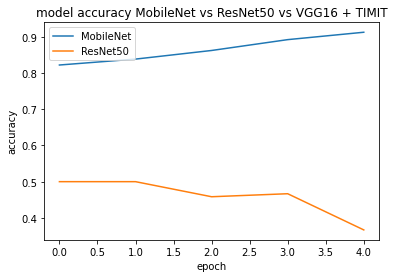

In [42]:
plt.plot(history_tiktalk.history['accuracy'])
plt.plot(history_tiktalk.history['val_accuracy'])
#plt.plot(history1_tiktalk.history['accuracy'])

#plt.plot(history1_rn_tiktalk.history['accuracy'])
#plt.plot(history1_vgg_tiktalk.history['accuracy'])
plt.title('model accuracy MobileNet vs ResNet50 vs VGG16 + TIMIT')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['MobileNet', 'ResNet50', 'VGG16'], loc='upper left')
plt.show()

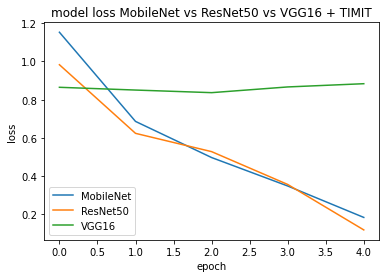

In [43]:
plt.plot(history1_tiktalk.history['loss'])
plt.plot(history1_rn_tiktalk.history['loss'])
plt.plot(history1_vgg_tiktalk.history['loss'])
plt.title('model loss MobileNet vs ResNet50 vs VGG16 + TIMIT')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['MobileNet', 'ResNet50', 'VGG16'], loc='lower left')
plt.show()

In [44]:
def checkAccuracy(path,model):
    filelist = glob.glob(path)
    predictions = []
    #j=0
    for i in filelist:
        image = tf.keras.preprocessing.image.load_img(path=i)
        input_arr = tf.keras.preprocessing.image.img_to_array(image)
        input_arr = np.array([input_arr])  # Convert single image to a batch.
        predictions.append(model.predict(input_arr))
        #j+=1
    return predictions



In [45]:
pathBad='../data/validation/Bad/*.png'
pathGood='../data/validation/Good/*.png'
predictionsBad = checkAccuracy(pathBad,model_tiktalk)
predictionsGood = checkAccuracy(pathGood,model_tiktalk)

In [112]:
countBad = 0
false_negative_mn=0
y_score_bad_mn = []
y_true_bad_mn = []
for pred in predictionsBad:
    y_true_bad_mn.append(0)
    y_score_bad_mn.append(pred[0][0])
    if(np.argmax(pred)==0):
        countBad+=1
    else:
        false_negative_mn+=1
accuracyBad = countBad/len(predictionsBad)

countGood = 0
false_positive_mn =0
y_score_good_mn = []
y_true_good_mn = []
for pred in predictionsGood:
    y_true_good_mn.append(1)
    y_score_good_mn.append(pred[0][1])
    if(np.argmax(pred)==1):
        countGood+=1
    else:
        false_positive_mn+=1
accuracyGood = countGood/len(predictionsGood)

total_acc = (accuracyGood + accuracyBad) /2

print('MobileNet + TIMIT accuracy = '+'%.3f'%total_acc)

MobileNet + TIMIT accuracy = 0.500


In [77]:
y_score_mn = np.append(y_score_bad_mn, y_score_good_mn)
y_true_mn = np.append(y_true_bad_mn, y_true_good_mn)

No Skill: ROC AUC=0.500
ResNet50: ROC AUC=0.500


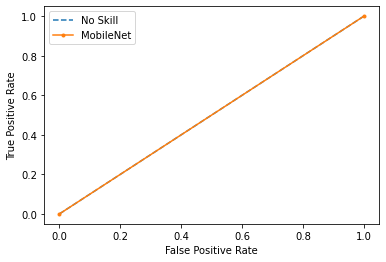

In [114]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_true_mn))]
# predict probabilities
lr_probs = y_score_mn
# calculate scores
ns_auc = roc_auc_score(y_true_mn, ns_probs)
lr_auc = roc_auc_score(y_true_mn, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('ResNet50: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_true_rn, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_true_rn, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='MobileNet')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [120]:
true_negative_mn = countBad
true_positive_mn = countGood
true_negative_mn

60

In [126]:
predictionsBad_rn = checkAccuracy(pathBad,model_rn_tiktalk)
predictionsGood_rn = checkAccuracy(pathGood,model_rn_tiktalk)

countBad = 0
false_negative_rn = 0
y_score_bad_rn = []
y_true_bad_rn = []
for pred in predictionsBad_rn:
    y_true_bad_rn.append(0)
    y_score_bad_rn.append(pred[0][0])
    if(np.argmax(pred)==0):
        countBad+=1
    else:
        false_negative_rn+=1
accuracyBad_rn = countBad/len(predictionsBad_rn)

countGood = 0
false_positive_rn=0
y_score_good_rn = []
y_true_good_rn = []
for pred in predictionsGood_rn:
    y_true_good_rn.append(1)
    y_score_good_rn.append(pred[0][1])
    if(np.argmax(pred)==1):
        countGood+=1
    else:
        false_positive_rn+=1
accuracyGood_rn = countGood/len(predictionsGood_rn)

total_acc_rn = (accuracyGood_rn + accuracyBad_rn) /2

print('ResNet50 + TIMIT accuracy = '+'%.3f'%total_acc_rn)

ResNet50 + TIMIT accuracy = 0.583


In [127]:
y_score_rn = np.append(y_score_bad_rn, y_score_good_rn)
y_true_rn = np.append(y_true_bad_rn, y_true_good_rn)

No Skill: ROC AUC=0.500
ResNet50: ROC AUC=0.609


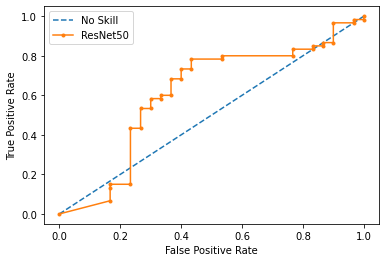

In [128]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_true_rn))]
# predict probabilities
lr_probs = y_score_rn
# calculate scores
ns_auc = roc_auc_score(y_true_rn, ns_probs)
lr_auc = roc_auc_score(y_true_rn, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('ResNet50: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_true_rn, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_true_rn, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='ResNet50')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [132]:
true_negative_rn = countBad
true_positive_rn = countGood
#true_positive_rn
#true_negative_rn
#false_positive_rn
#false_negative_rn

34

In [137]:
predictionsBad_vgg = checkAccuracy(pathBad,model_vgg_tiktalk)
predictionsGood_vgg = checkAccuracy(pathGood,model_vgg_tiktalk)

countBad = 0
false_negative_vgg = 0
y_score_bad_vgg = []
y_true_bad_vgg = []
for pred in predictionsBad_vgg:
    y_true_bad_vgg.append(0)
    y_score_bad_vgg.append(pred[0][0])
    if(np.argmax(pred)==0):
        countBad+=1
        #y_score_bad_vgg.append(0)
    else:
        false_negative_vgg+=1
        #y_score_bad_vgg.append(1)
accuracyBad_vgg = countBad/len(predictionsBad_vgg)
#print('Bad Accuracy MobileNet = '+'%.3f'%accuracyBad)

countGood = 0
false_positive_vgg=0
y_score_good_vgg = []
y_true_good_vgg = []
for pred in predictionsGood_vgg:
    y_true_good_vgg.append(1)
    y_score_good_vgg.append(pred[0][1])
    if(np.argmax(pred)==1):
        countGood+=1
        #y_score_good_vgg.append(pred[1])
    else:
        false_positive_vgg+=1
        #y_score_good_vgg.append(pred[0])
accuracyGood_vgg = countGood/len(predictionsGood_vgg)
#print('Good Accuracy MobileNet = '+'%.3f'%accuracyGood)

total_acc_vgg = (accuracyGood_vgg + accuracyBad_vgg) /2

print('VGG16 + TIMIT accuracy = '+'%.3f'%total_acc_vgg)

VGG16 + TIMIT accuracy = 0.500


In [138]:
y_score_vgg = np.append(y_score_bad_vgg, y_score_good_vgg)
y_true_vgg = np.append(y_true_bad_vgg, y_true_good_vgg)

No Skill: ROC AUC=0.500
VGG16: ROC AUC=1.000


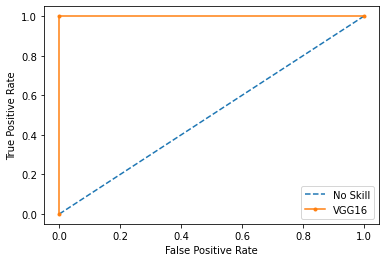

In [139]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_true_vgg))]
# predict probabilities
lr_probs = y_score_vgg
# calculate scores
ns_auc = roc_auc_score(y_true_vgg, ns_probs)
lr_auc = roc_auc_score(y_true_vgg, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('VGG16: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_true_vgg, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_true_vgg, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='VGG16')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [143]:
true_negative_vgg = countBad
true_positive_vgg = countGood
#true_positive_vgg
#true_negative_vgg
#false_positive_vgg
false_negative_vgg

60

In [59]:
Sensitivity_rn = true_positive_rn / (true_positive_rn + false_negative_rn)
true_positive_rate_rn = true_positive_rn / (true_positive_rn + false_negative_rn)
false_positive_rate_rn = false_negative_rn / (false_positive_rn + true_negative_rn)
specificity_rn = true_negative_rn / (true_negative_rn + false_positive_rn)


In [55]:
Sensitivity_rn

0.5641025641025641

In [61]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

In [63]:
false_positive_rate_rn, true_positive_rate_rn, _ = roc_curve([1,2,3,4,5,6], 0.583)
# plot the roc curve for the model
pyplot.plot(false_positive_rate_rn, true_positive_rate_rn, linestyle='--', label='No Skill')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

ValueError: multiclass format is not supported